### Load packages and sample data

In [1]:
import shlex
import re
import pandas as pd
from typing import List
import utils

In [2]:
fields_to_include = ["OWNER","TITLE", "ABSTRACT", "SERVICETYPE", "SERVICELINK", "KEYWORDS"]
fields_to_output = ["OWNER","TITLE", "SERVICETYPE", "SERVICELINK"]
url_github_repo = "https://github.com/davidoesch/geoservice_harvester_poc/blob/main/data/"
url_github_repo_suffix = "?raw=true"
url_geoservices_CH_csv = "{}geoservices_CH.csv{}".format(url_github_repo,url_github_repo_suffix)
a = 'Strassen auswertung system'

def split_delimiters(word_list_with_delimiters: List[str]) -> List[str]:
    """Take care of left over delimiters, split strings even if in qoutes
        Return a list of words """
    delimiters = [";", ","]

    new_word_list = []

    for word in word_list_with_delimiters:
        if (any(delimiter in word for delimiter in delimiters)):
            splitted_words = re.split(r',|;', word)
            for splitted_word_ in splitted_words:
                new_word_list.append(splitted_word_)
        else:
            new_word_list.append(word)
    return new_word_list

def load_data():
    dataframe = pd.read_csv(url_geoservices_CH_csv, usecols=fields_to_include)
    return dataframe

res = split_delimiters(shlex.split(a))
dataframe_some_cols = load_data()
result = dataframe_some_cols[dataframe_some_cols.apply(lambda dataset: dataset.astype(str).str.contains(res[0], case=False).any(), axis=1)]
database =result.fillna("empty")

### Improvement of the TF-IDF with BM25 to execute queries on the text

In [5]:
# abstracts = result['ABSTRACT'].values.tolist()
bm25 = utils.TFIDF_BM25()
bm25.cleansing_ranking(database, column='ABSTRACT') # 1421 lines in 36 s

In [6]:
# fit the vector to the database
bm25.fit()
# search the best match in the vector
res = bm25.search('Brandmeldeanlage')

In [7]:
for el in res:
    print(result.loc[el])

OWNER                                                      KT_AR
TITLE                                          Feuerwehrplan Gde
ABSTRACT       Der Übersichtsplan der Feuerwehr enthält folge...
KEYWORDS                                                     NaN
SERVICELINK    https://www.geoportal.ch/services/wms/ktar?ser...
SERVICETYPE                                                  WMS
Name: 224, dtype: object


### Keyword extraction with rake_nltk

In [3]:
rake = utils.KeywordsRake()
keywords = rake.extract_keywords(database, column='ABSTRACT', score=False, keyword_length=3)


In [6]:
keywords[0][:8]

['wms service geoportal',
 'kanton appenzell innerrhoden',
 'meteorwasser sowie versickerungsanlagen',
 'karte zeigt',
 'kanalisationsnetz dargestellt',
 'darin ersichtlich',
 'sowie',
 'ölabscheider']

In [7]:
database['ABSTRACT'].values.tolist()[0]

'Diese Karte zeigt die Werkleitungen der Abwasserentsorgung an. Es wird die Strassenentwässerung und Liegenschaftsentwässerung (teilweise mit Hausanschluss) sowie das Kanalisationsnetz dargestellt. Darin ersichtlich sind unter anderem Leitungen mit Schmutzabwasser, Mischabwasser, Regenabwasser, Meteorwasser sowie Versickerungsanlagen, Kontrollschächte, Einlaufschächte und Ölabscheider. WMS Service Geoportal - Kanton Appenzell Innerrhoden'

### Implement the classification and keyword extraction with spacy (NLP)

In [3]:
NLP = utils.NLP_spacy()
keywords = NLP.extract_keywords(database, column='ABSTRACT') # with small models

In [13]:
keywords[2]

[Bundesamtes für Strassen,,
 swisstopo bezogen.,
 Hauptstrassen,
 schweizerischer,
 Hauptstrassen,
 Hauptstrassen,
 Sachverhalten,
 Strassen,
 Geoportal]

In [14]:
# Original abstract
database['ABSTRACT'].values.tolist()[2]

'Geodaten des Bundesamtes für Strassen, als WMS der swisstopo bezogen. Der Datensatz der Hauptstrassen umfasst Strassen von allgemein schweizerischer oder internationaler Bedeutung, die nicht als Nationalstrasse definiert sind. Hauptstrassen stellen sowohl die Durchleitung des nationalen und internationalen Verkehrs, als auch die wichtigsten regionalen Verbindungen sicher. Die Achsen der Hauptstrassen können für die Beschreibung und die Referenzierung von Sachverhalten entlang der Strassen verwendet werden. WMS Service Geoportal - Kanton Appenzell Innerrhoden'

### Test LSA and LSI with gensim for topic modelling

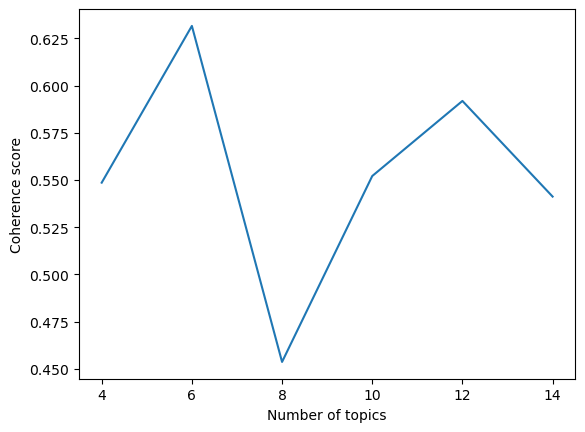

In [11]:
LSA = utils.LSI()
LSA.preprocess(database)
LSA.compute_coherence_values((4,16,2))

In [14]:
best_number_topics = 12
number_of_words = 10
lsamodel = LSA.create_gensim_lsa_model(best_number_topics, number_of_words)

[(0, '-0.439*"art" + -0.432*"tvav" + -0.239*"enthalt" + -0.209*"dateneb" + -0.199*"definiert" + -0.192*"punkt" + -0.172*"fehl" + -0.172*"mittl" + -0.172*"toleranzstuf" + -0.172*"standardabweich"'), (1, '0.416*"kanton" + 0.293*"wurd" + 0.281*"bern" + 0.233*"datensatz" + 0.230*"https" + 0.209*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingungen_de.pdf" + 0.147*"\'\'" + 0.146*"``" + 0.137*"gemass" + 0.129*"fff"'), (2, '0.435*"sitz" + -0.336*"\'\'" + -0.334*"``" + 0.326*"bern" + -0.306*"datensatz" + 0.148*"https" + 0.142*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingungen_de.pdf" + 0.125*"regionalgericht" + 0.094*"thun" + 0.094*"grenz"'), (3, '-0.508*"fff" + 0.293*"wurd" + 0.211*"\'\'" + 0.210*"``" + -0.187*"sachplan" + 0.156*"gewasserraum" + 0.152*"sitz" + -0.135*"gemass" + -0.127*"fruchtfolgeflach" + -0.120*"flach"'), (4, '0.355*"sitz" + 0.309*"datensatz" + -0.308*"gewasserraum" + -0.283*"wurd" + -0.191*"nutzungseinschrank" + 0.152*"\'\'" + 0.151*"``" + -0.

In [15]:
lsamodel.print_topics(best_number_topics, number_of_words)

[(0,
  '-0.439*"art" + -0.432*"tvav" + -0.239*"enthalt" + -0.209*"dateneb" + -0.199*"definiert" + -0.192*"punkt" + -0.172*"fehl" + -0.172*"mittl" + -0.172*"toleranzstuf" + -0.172*"standardabweich"'),
 (1,
  '0.416*"kanton" + 0.293*"wurd" + 0.281*"bern" + 0.233*"datensatz" + 0.230*"https" + 0.209*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingungen_de.pdf" + 0.147*"\'\'" + 0.146*"``" + 0.137*"gemass" + 0.129*"fff"'),
 (2,
  '0.435*"sitz" + -0.336*"\'\'" + -0.334*"``" + 0.326*"bern" + -0.306*"datensatz" + 0.148*"https" + 0.142*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingungen_de.pdf" + 0.125*"regionalgericht" + 0.094*"thun" + 0.094*"grenz"'),
 (3,
  '-0.508*"fff" + 0.293*"wurd" + 0.211*"\'\'" + 0.210*"``" + -0.187*"sachplan" + 0.156*"gewasserraum" + 0.152*"sitz" + -0.135*"gemass" + -0.127*"fruchtfolgeflach" + -0.120*"flach"'),
 (4,
  '0.355*"sitz" + 0.309*"datensatz" + -0.308*"gewasserraum" + -0.283*"wurd" + -0.191*"nutzungseinschrank" + 0.152*"\'\'" + 0.

### Test Text Summarization and Latent Dirchlet allocation (LDA) for topic modeling

In [16]:
# TODO
# https://towardsdatascience.com/text-summarization-for-clustering-documents-2e074da6437a
# https://towardsdatascience.com/nlp-topic-modeling-to-identify-clusters-ca207244d04f

### Topic modeling with PyTorch models and predefined categories

In [18]:
# TODO
# https://github.com/davidoesch/geoservice_harvester_poc/issues/5

### Possible ddditional tests

In [ ]:
# Jaccard/Cosine similarity -> for query search
# WordNet-word-similarity -> for query search